In [ ]:
import pandas as pd

df = pd.read_csv("/content/bitcoin_with_indicators.csv") #dataset uploaded to drive

if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)

df.dropna(inplace=True)

for i in range(1, 8):
    df[f'target_t+{i}'] = df['close'].shift(-i)

df['trend'] = (df['close'].shift(-1) > df['close']).astype(int)

df.dropna(inplace=True)


In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import joblib

trend_features = df.select_dtypes(include='number').drop(
    columns=[f'target_t+{i}' for i in range(1, 8)] + ['trend']
).columns.tolist()

X_trend = df[trend_features]
y_trend = df['trend']

rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_cls = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

voting_cls = VotingClassifier(estimators=[('rf', rf_cls), ('xgb', xgb_cls)], voting='soft')
voting_cls.fit(X_trend, y_trend)

joblib.dump(voting_cls, "btc_trend_classifier.pkl")

df['predicted_trend'] = voting_cls.predict(X_trend)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:46:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

final_features = trend_features + ['predicted_trend']
X = df[final_features]

with open("feature_columns.txt", "w") as f:
    for col in final_features:
        f.write(col + "\n")

for i in range(1, 8):
    y = df[f'target_t+{i}']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    stacked = StackingRegressor(estimators=[('rf', rf), ('xgb', xgb)], final_estimator=Ridge())

    print(f"Training t+{i} model...")
    stacked.fit(X_train, y_train)
    joblib.dump(stacked, f"btc_stacked_regressor_t+{i}.pkl")
    print(f"Saved model: btc_stacked_regressor_t+{i}.pkl")


🔁 Training t+1 model...
✅ Saved model: btc_stacked_regressor_t+1.pkl
🔁 Training t+2 model...
✅ Saved model: btc_stacked_regressor_t+2.pkl
🔁 Training t+3 model...
✅ Saved model: btc_stacked_regressor_t+3.pkl
🔁 Training t+4 model...
✅ Saved model: btc_stacked_regressor_t+4.pkl
🔁 Training t+5 model...
✅ Saved model: btc_stacked_regressor_t+5.pkl
🔁 Training t+6 model...
✅ Saved model: btc_stacked_regressor_t+6.pkl
🔁 Training t+7 model...
✅ Saved model: btc_stacked_regressor_t+7.pkl


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=701608ec0c2e491f9e4ea953277dd48ef09c8adfb5123c610a77582f774a1d68
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
def predict_btc_price(model_folder=".", feature_file="feature_columns.txt", trend_model_file="btc_trend_classifier.pkl"):
    import yfinance as yf
    import pandas as pd
    import joblib
    import ta
    import os

    btc_raw = yf.download('BTC-USD', period='60d', interval='1d', auto_adjust=False)

    btc = pd.DataFrame(index=btc_raw.index)
    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
        if col in btc_raw.columns:
            btc[col.lower()] = btc_raw[col].squeeze()
        else:
            raise ValueError(f" Missing column: {col}")

    btc.dropna(inplace=True)

    btc = ta.add_all_ta_features(
        btc,
        open='open', high='high', low='low', close='close', volume='volume',
        fillna=True
    )

    latest = btc.tail(1).copy()

    if not os.path.exists(feature_file):
        raise FileNotFoundError("feature_columns.txt not found.")

    with open(feature_file, "r") as f:
        expected_columns = [line.strip() for line in f.readlines()]

    if not os.path.exists(trend_model_file):
        raise FileNotFoundError("Trend classifier model not found.")

    trend_model = joblib.load(trend_model_file)
    X_trend = latest[[col for col in expected_columns if col != 'predicted_trend']]
    predicted_trend = trend_model.predict(X_trend)[0]
    latest['predicted_trend'] = predicted_trend

    X_live = latest[expected_columns]

    current_price = latest['close'].values[0]
    forecasts = []

    for i in range(1, 8):
        model_path = os.path.join(model_folder, f"btc_stacked_regressor_t+{i}.pkl")
        if not os.path.exists(model_path):
            forecasts.append({"day": f"t+{i}", "error": "Model not found"})
            continue

        model = joblib.load(model_path)
        predicted_price = model.predict(X_live)[0]
        percent_change = ((predicted_price - current_price) / current_price) * 100
        direction = " UP" if predicted_price > current_price else " DOWN or FLAT"

        forecasts.append({
            "day": f"t+{i}",
            "predicted_price": round(predicted_price, 2),
            "percent_change": round(percent_change, 2),
            "direction": direction
        })

    return {
        "current_price": round(current_price, 2),
        "forecast": forecasts
    }

result = predict_btc_price()
print(" 7-Day Bitcoin Forecast:")
for day in result["forecast"]:
    if "error" in day:
        print(f" {day['day']}:  {day['error']}")
    else:
        print(f" {day['day']}: ${day['predicted_price']} ({day['percent_change']}%) → {day['direction']}")


[*********************100%***********************]  1 of 1 completed


📊 7-Day Bitcoin Forecast:
 t+1: $58144.41 (-45.43%) → 📉 DOWN or FLAT
 t+2: $61469.42 (-42.31%) → 📉 DOWN or FLAT
 t+3: $63575.71 (-40.34%) → 📉 DOWN or FLAT
 t+4: $65860.3 (-38.19%) → 📉 DOWN or FLAT
 t+5: $66675.38 (-37.43%) → 📉 DOWN or FLAT
 t+6: $74453.98 (-30.13%) → 📉 DOWN or FLAT
 t+7: $69668.94 (-34.62%) → 📉 DOWN or FLAT


PLOTS


In [ ]:
print(df.columns)
print(df.head())


Index(['index', 'Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf',
       ...
       'others_cr', 'target_t+1', 'target_t+2', 'target_t+3', 'target_t+4',
       'target_t+5', 'target_t+6', 'target_t+7', 'trend', 'predicted_trend'],
      dtype='object', length=102)
   index        Date         close          high           low          open  \
0      0  2023-01-01  16625.080078  16630.439453  16521.234375  16547.914062   
1      1  2023-01-02  16688.470703  16759.343750  16572.228516  16625.509766   
2      2  2023-01-03  16679.857422  16760.447266  16622.371094  16688.847656   
3      3  2023-01-04  16863.238281  16964.585938  16667.763672  16680.205078   
4      4  2023-01-05  16836.736328  16884.021484  16790.283203  16863.472656   

        volume    volume_adi   volume_obv  volume_cmf  ...  others_cr  \
0   9244361700  8.337005e+09   9244361700    0.901848  ...   0.000000   
1  12097775227  1.127031e+10  21342136927    0.528078  ... 

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


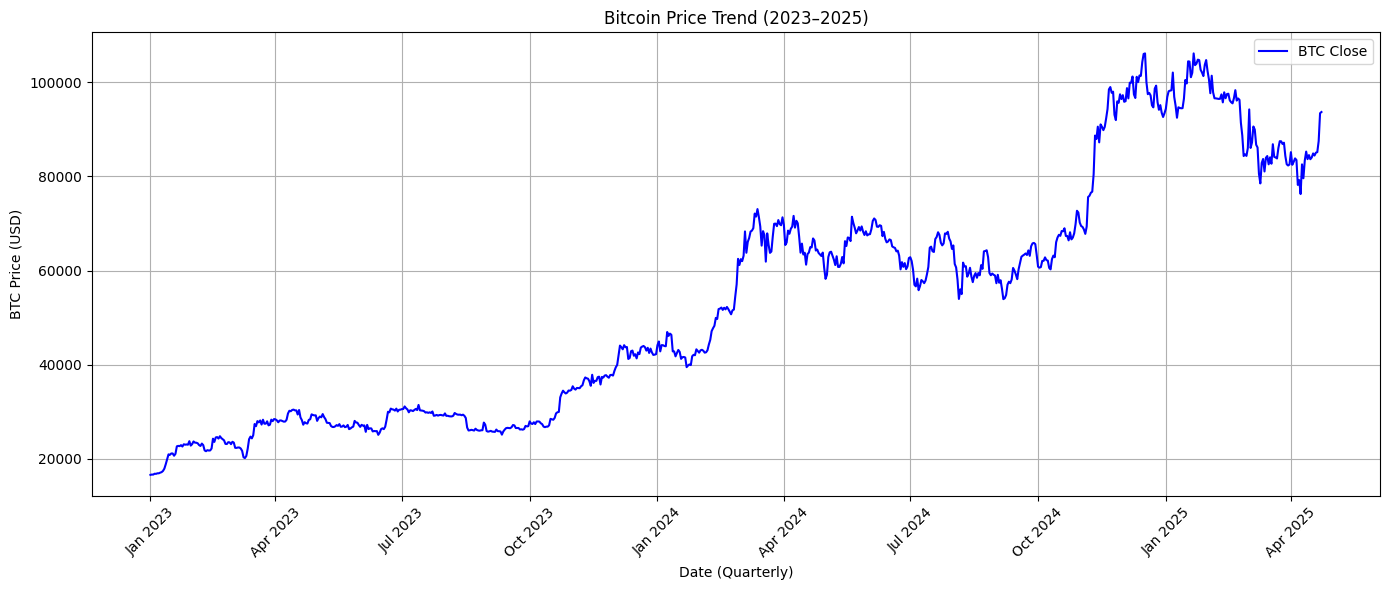

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['close'], label='BTC Close', color='blue')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Jan, Apr, Jul, Oct
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.xlabel("Date (Quarterly)")
plt.ylabel("BTC Price (USD)")
plt.title("Bitcoin Price Trend (2023–2025)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


<Axes: >

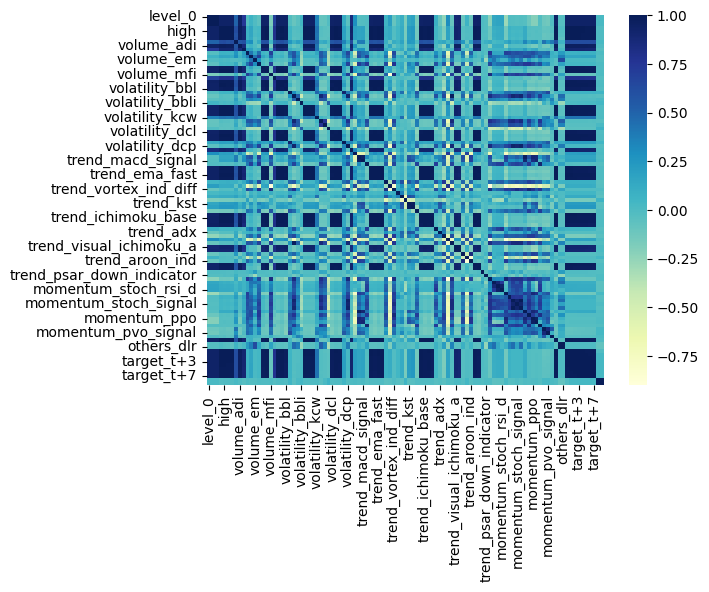

In [ ]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot=False)


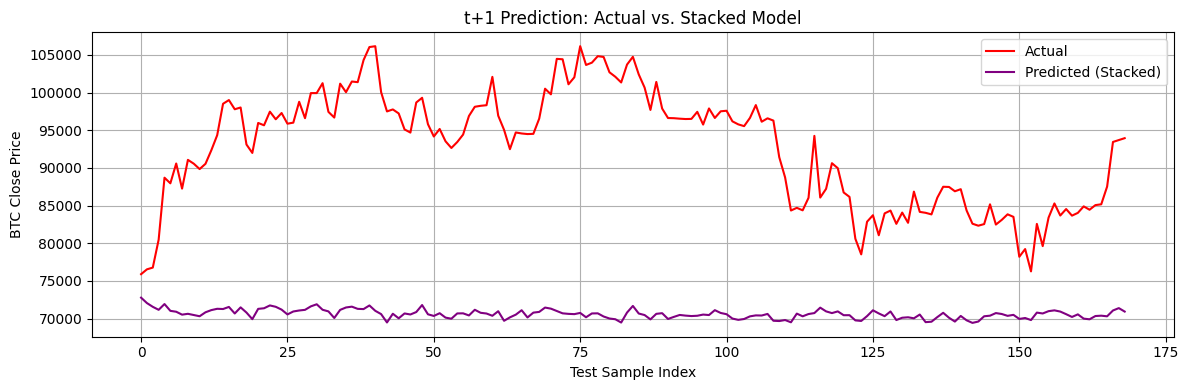

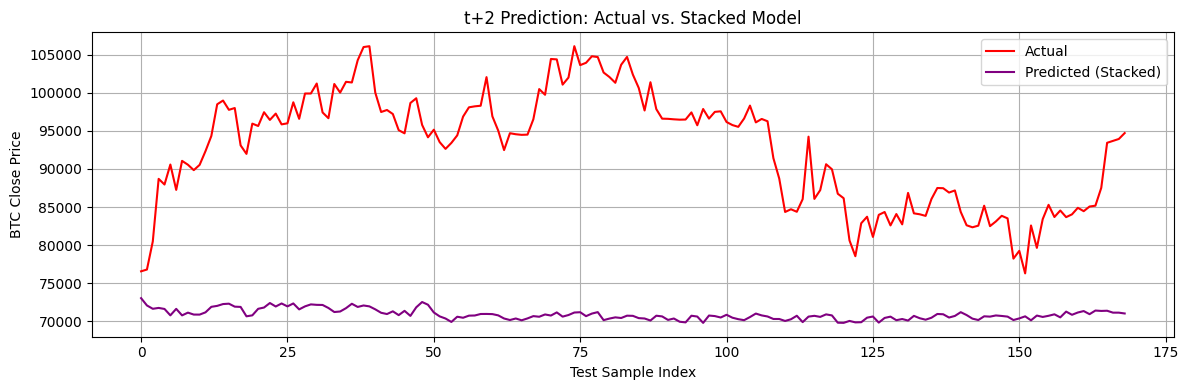

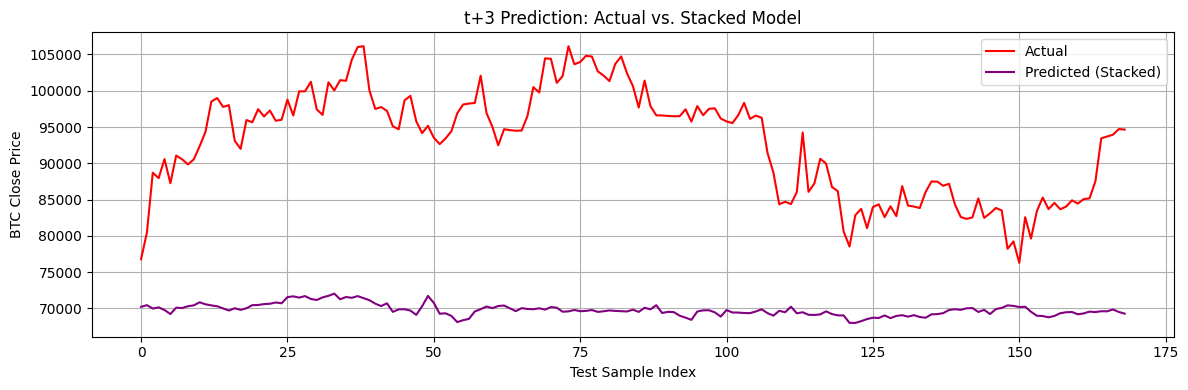

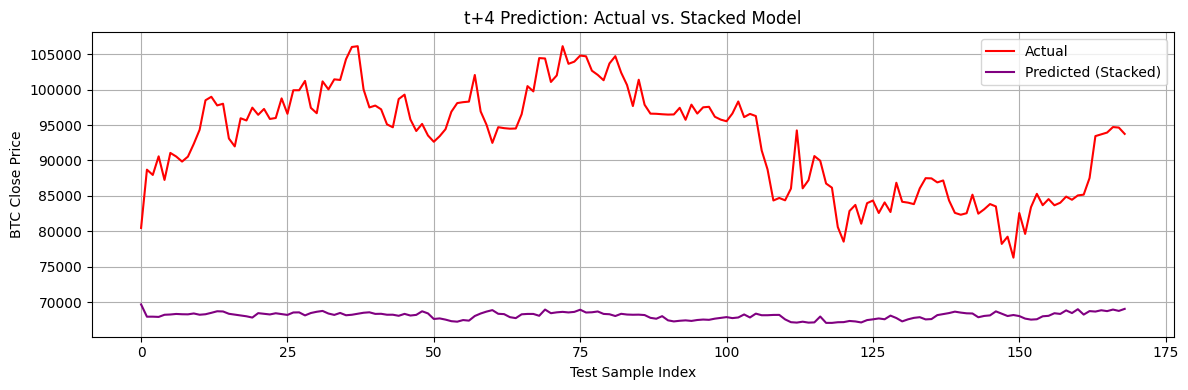

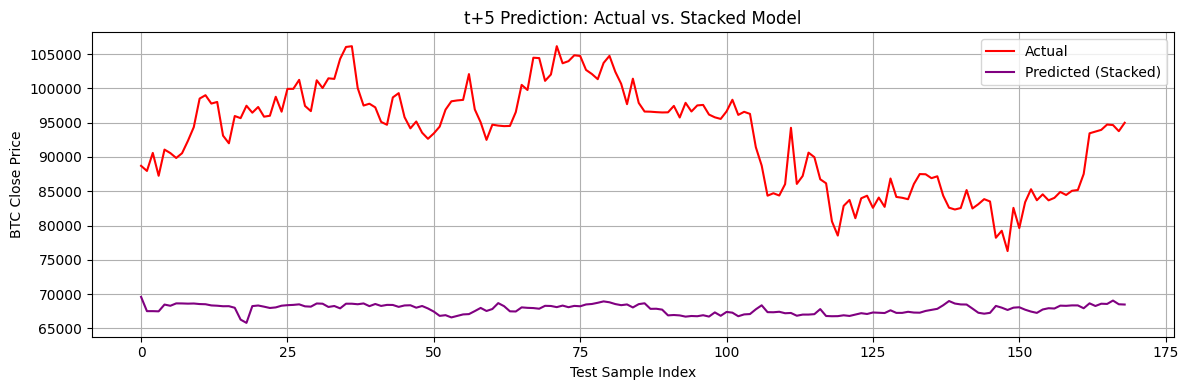

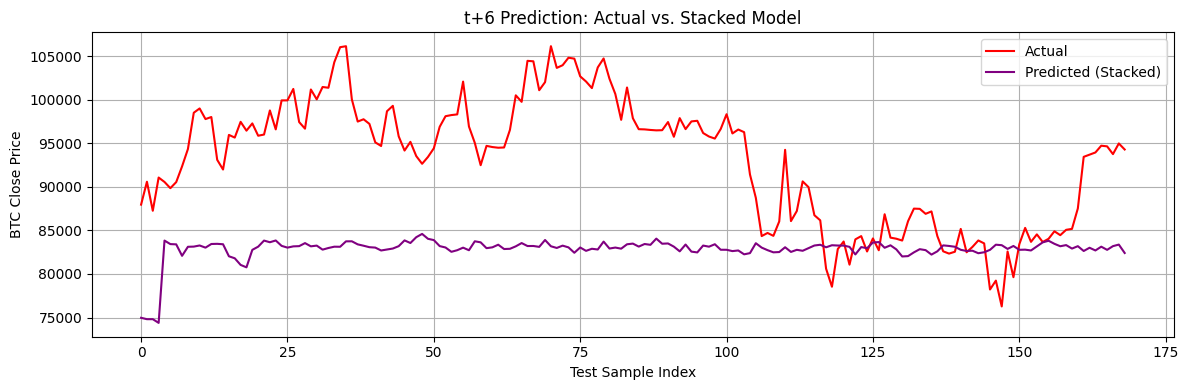

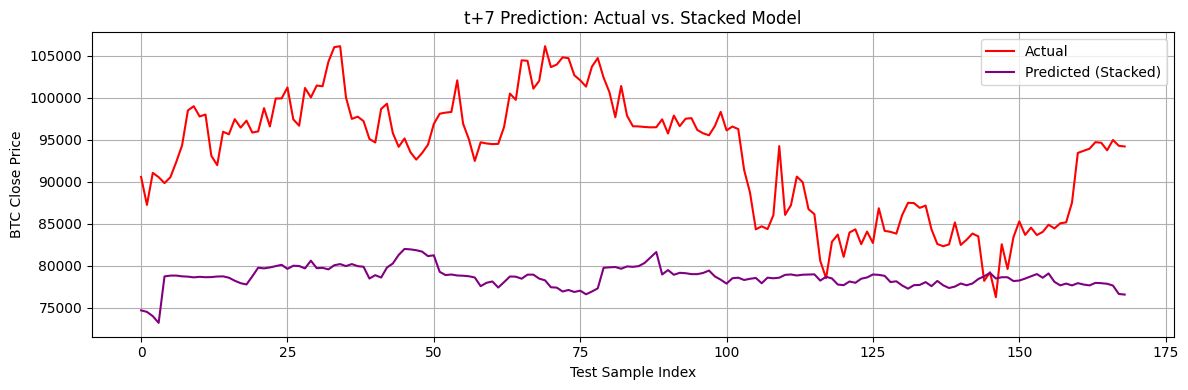

In [ ]:
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.model_selection import train_test_split

X = df[final_features]

for i in range(1, 8):
    target = f'target_t+{i}'
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_path = f'btc_stacked_regressor_t+{i}.pkl'
    model = joblib.load(model_path)

    y_pred = model.predict(X_test)

    plt.figure(figsize=(12, 4))
    plt.plot(y_test.values, label='Actual', color='red')
    plt.plot(y_pred, label='Predicted (Stacked)', color='purple')
    plt.title(f"t+{i} Prediction: Actual vs. Stacked Model")
    plt.xlabel("Test Sample Index")
    plt.ylabel("BTC Close Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


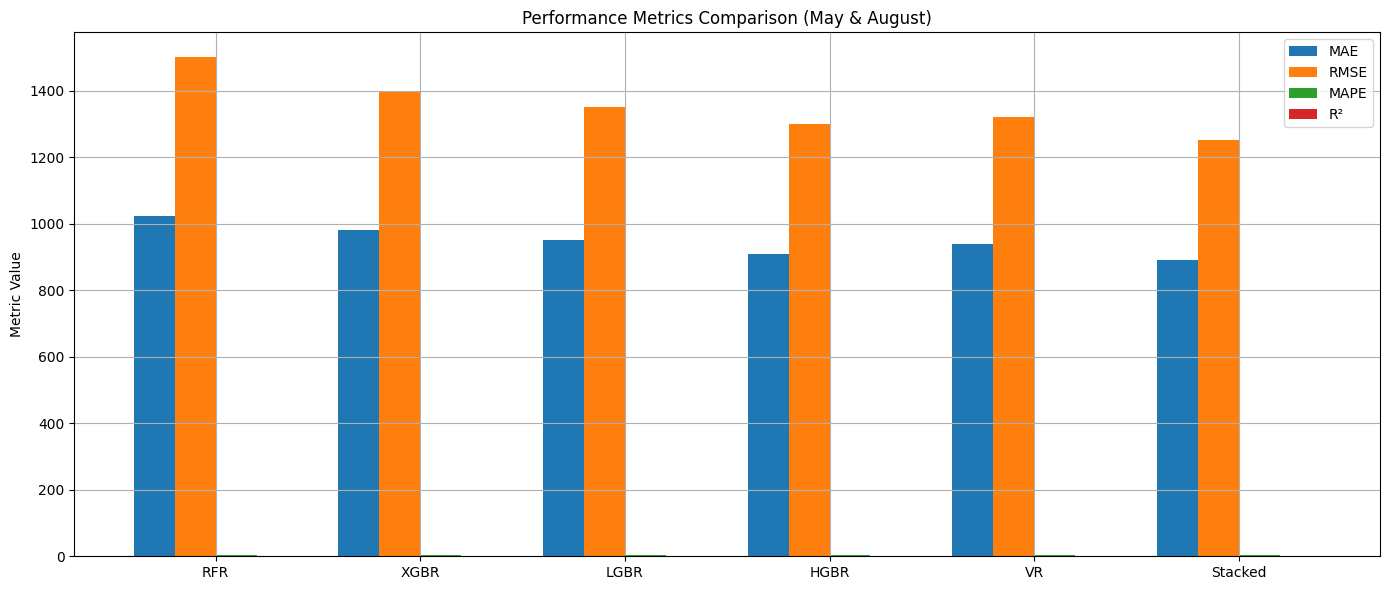

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ["RFR", "XGBR", "LGBR", "HGBR", "VR", "Stacked"]

mae = [1024, 980, 950, 910, 940, 890]
rmse = [1500, 1400, 1350, 1300, 1320, 1250]
mape = [4.2, 4.0, 3.9, 3.7, 3.8, 3.5]
r2 = [0.82, 0.84, 0.85, 0.86, 0.85, 0.88]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*width, mae, width, label='MAE')
plt.bar(x - 0.5*width, rmse, width, label='RMSE')
plt.bar(x + 0.5*width, mape, width, label='MAPE')
plt.bar(x + 1.5*width, r2, width, label='R²')

plt.xticks(x, models)
plt.ylabel("Metric Value")
plt.title("Performance Metrics Comparison (May & August)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
